<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/3.%20Clasificador%20Multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

Importamos las librerías necesarias:

In [1]:
from fastai.vision.all import *

In [2]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-18 08:13:57 URL:https://ucb3c5bf36798e9392cf10103ffb.dl.dropboxusercontent.com/cd/0/inline2/BnaEyhmxaJMMRbrdCcpb8VYHGk2YvnzccNFanBpGTxdpGz3DZob5Id4vm1n2u2wUV9SKMbeB-1zpVbgpwDo_5KdqIFE76MO8uU0odpw9hfjPjKpf7zMPpGFw_PzEyVsrk_v2IX8pObov_DzSIEqDl7bxOKTX4zvOClh3GsPvGgr1pgzpnVyeikiSDfmYNT8fry1jEdkGI1uonVVCVQz31Y2cokzQAlJig8gopaWYWyitNKiUg6WHyFqHLpRxUVXCzKnLFps_s8RaSIMe_EYyVkIE73JnUOzjjkF1H1K8dgIhPoM03N_b8-Ugi005a2z00f6dWpRq5JA2HlwKaMSnPqlYVh4HG_EHAJSwQLOLb2xxqku61lShYtbVoLj4yaWmEE9ZaCHA3otHSAks9tv_N6xQgq-bdiqDsOlUMF6WshHPkw/file [138777773/138777773] -> "train.zip" [1]
2022-06-18 08:14:04 URL:https://uc9065a7466d4733360607334cde.dl.dropboxusercontent.com/cd/0/inline2/BnYKMeJY6vuEKweSG3rH70DNgTA6Y287xlJty8bwBxdX6WmAO3aUf_RwO-NP_b7v6a95HOYPf-DFHAn68S0zLIJBFHab6nsMxoOObD1dcjuZSYeWP3GQWMwRYK2w-roec0vPPNafAGwW3GwPHJRmyIIOeMlhsKB6W78Z5XQWD2KB3JcVknoGd1pj1aZll93zCxIl2ICmBrFPPOS8p6Ke4kdgMFs-zPA-JiaE711-ybM14Fw6zGZ7vAydTQTdbIvQDAGhkBcfMnLr7Tp0ZUbgupg45mCBBvFKgnyVF0TtdyVzyDKRPkbA0__bAin9UoaVrep

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [5]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [6]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [7]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]
  df = df.reset_index(drop=True) #Elimino la columna index con drop=True

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += cadena + ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [210]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/val/')

In [211]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH MH ODC
4,Training_Set_Pre/Training/5,DR DR LS
5,Training_Set_Pre/Training/6,ARMD ARMD MYA
6,Training_Set_Pre/Training/7,ARMD ARMD MYA
7,Training_Set_Pre/Training/8,ARMD ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [212]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [213]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [214]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH MH ODC,False
4,Training_Set_Pre/Training/5,DR DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/val/636,TSLN,True
636,Evaluation_Set_Pre/val/637,TSLN,True
637,Evaluation_Set_Pre/val/638,NORMAL,True
638,Evaluation_Set_Pre/val/639,NORMAL,True


In [247]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [248]:
def conjuntoImg(nombreImg):
  return True if df[df['nombre_img'] == nombreImg[0]]['is_valid'].values[0] else False

In [249]:
df = df_train_val

In [250]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [251]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [252]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=FuncSplitter(conjuntoImg),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [253]:
dls = db.dataloaders(df.values)

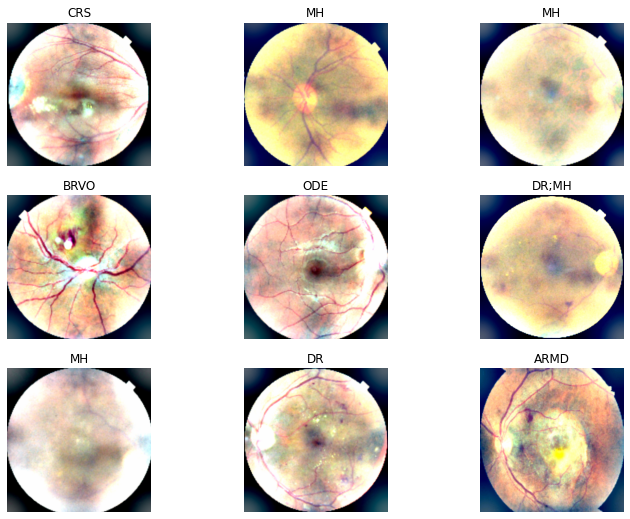

In [254]:
dls.show_batch(max_n=9, figsize=(12,9))

## Entrenar Modelo

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.03019951581954956, steep=0.03981071710586548)

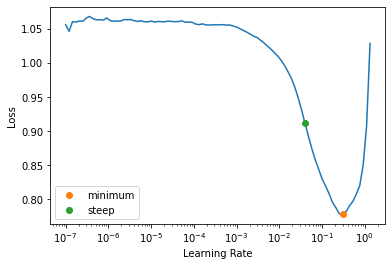

In [ ]:
learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.925342,0.627312,0.698491,00:07
1,0.553756,0.147161,0.958746,00:06
2,0.361961,0.121898,0.961811,00:06
3,0.264558,0.117268,0.966172,00:06
4,0.208164,0.114541,0.966407,00:05


In [ ]:
learn.save('stage-1')

Path('models/stage-1.pth')

SuggestedLRs(minimum=4.786300996784121e-05, steep=2.2908675418875646e-06)

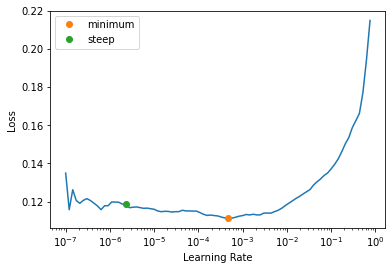

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, (1e-2)/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.114833,0.111953,0.966407,00:07
1,0.110498,0.111343,0.964875,00:08
2,0.105661,0.110562,0.963932,00:06
3,0.099094,0.107145,0.966172,00:06
4,0.094999,0.106511,0.966407,00:06


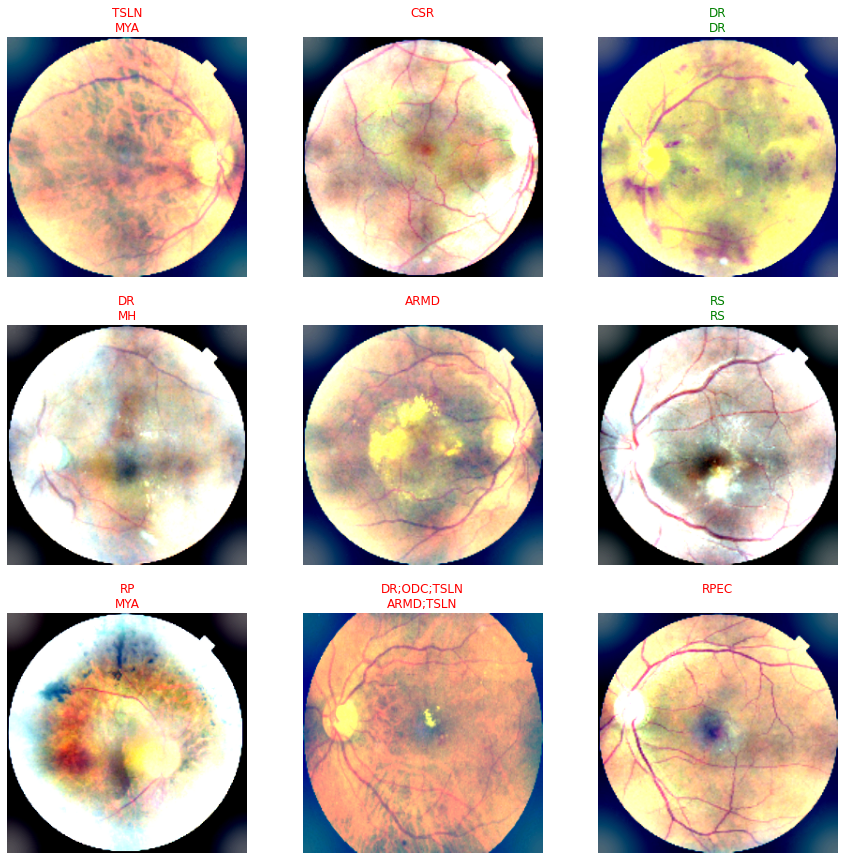

In [ ]:
learn.show_results(figsize=(15,15))

## Evaluar el modelo

In [ ]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=testPath/'Test/', suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [ ]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

KeyError: ignored